# COVID-19 Prediction using Transfer Learning

I'll be using transfer learning on a pre-trained CNN to build an COVID-19/Normal classifier!

<img src="TransferLearning.png" style="width:700px;height:300px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows us to use it to customize our own model cheaply and efficiently. The one we'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

## Table of Content

- [1 - Import Packages](#5)
- [2 - Data Preprocess and Augmentation](#2)
    - [2.1 - Data Augmentation](#ex-1)
        - [Rescale Pixel Values](#)
    - [2.2 Create the Dataset in Training and Validation Sets](#3-3)
- [3 - Creating the base model from the pre-trained Convnets](#3-3)
    - [3.1 - Inside a Transfer Learning  Building Block](#3-3)
    - [3.2 - Layer Freezing with the Functional API](#)
- [4 - Compile the model](#3-3)
    - [4.1 - Train the model](#3-3)
    - [4.2 - Learning Curve](#ex-3)
- [5 - Confusion Matrix](#)
    - [5.1 - AUC & ROC Curve](#3-3)
- [6 - Fine Tuning](#)
    - [6.1 - Compile the model](#3-3)
    - [6.1 - Continure Training the Model](#3-3)
        - [Learning Curve](#ex-3)
- [7 - Evaluation and Prediction](#)

<font color='blue'>
    
## 1. Importing Packages

In [147]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.models import Sequential
from keras.models import load_model

from keras.preprocessing import image
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score


<font color='blue'>

## 2. Data Preprocess and Augmentation

### 2.1 Data Augmentation

To increase diversity in the training set and help our model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. 

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). More details about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

Official documents for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

#### Rescale Pixel Values

In a moment, we will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in our images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [149]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode="nearest",
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rotation_range=20,
                                   horizontal_flip = True)

In [150]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

### 2.2 Create the Dataset in Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `flow_from_directory()` to read from the directory and create both training and validation datasets. 

In [151]:
INIT_LR = 1e-3
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
directory = "Dataset/"

In [152]:
# Train Datasets
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/Train',
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 11046 images belonging to 2 classes.


In [153]:
class_names = training_set.class_indices
print(class_names)

{'Covid': 0, 'Normal': 1}


In [154]:
# Validation Datasets
validation_set = validation_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/Validation',
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 2762 images belonging to 2 classes.


In [155]:
class_names = validation_set.class_indices
print(class_names)

{'Covid': 0, 'Normal': 1}


Now let's take a look at some of the Augumented images from the training set.

    First nine images and labels from the training set:

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


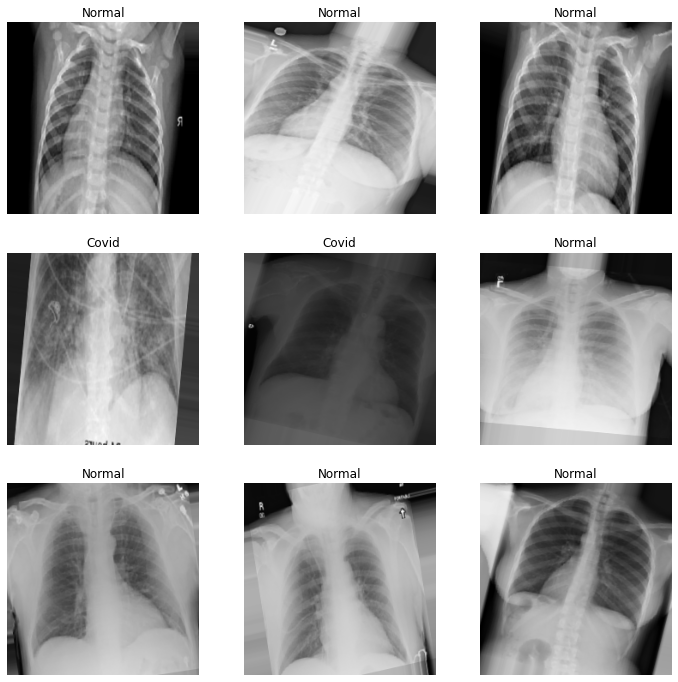

In [156]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = training_set.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'Covid', 1:'Normal'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

<font color='blue'>

## 3. Creating the base model from the pre-trained Convnets

We will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we need to pick which layer of MobileNet V2 we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="mobilenet.png" style="width:650px;height:450px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

### 3.2 Layer Freezing with the Functional API

We will see how we can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [158]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [159]:
# add preprocessing layer to the front of mobile_net
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [160]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)

In [162]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
	layer.trainable = False

In [163]:
# # don't train existing weights
# for layer in base_model.layers:
#   layer.trainable = False

In [164]:
# # useful for getting number of classes
# folders = glob('/content/drive/MyDrive/Dataset/Train/*')

In [165]:
# # our layers - you can add more if you want
# x = Flatten()(base_model.output)
# # x = Dense(1000, activation='softmax')(x)
# prediction = Dense(len(folders), activation='softmax')(x)

In [166]:
# # create a model object
# model = Model(inputs=base_model.input, outputs=prediction)

In [167]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [168]:
nb_layers = len(model.layers)
print(nb_layers)

159


In [171]:
print(base_model.layers[nb_layers - 8].name)
print(base_model.layers[nb_layers - 7].name)

Conv_1
Conv_1_bn


#### Not Important just for validation of our model

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [172]:
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(32, 7, 7, 1280)


In [173]:
# Not so Important just for validation of our model
#Shows the different label probabilities in one tensor 
label_batch

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

Now decode the predictions made by the model. Earlier, when we printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.


<font color='blue'>

## 4. Compile the Model

In [174]:
# tell the model what cost and optimization method to use
EPOCHS = 20
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [175]:
len(model.trainable_variables)

4

### 4.1 Train the Model

In [176]:
# fit the model
# initial_epochs = 10
history = model.fit_generator(training_set,
                        validation_data=validation_set,
                        epochs=EPOCHS,
                        steps_per_epoch=len(training_set),
                        validation_steps=len(validation_set))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
346/346 [==============================] - 204s 578ms/step - loss: 0.3760 - accuracy: 0.8474 - val_loss: 0.3047 - val_accuracy: 0.8686
Epoch 2/20
346/346 [==============================] - 201s 581ms/step - loss: 0.3166 - accuracy: 0.8755 - val_loss: 0.2687 - val_accuracy: 0.8838
Epoch 3/20
346/346 [==============================] - 197s 568ms/step - loss: 0.2875 - accuracy: 0.8849 - val_loss: 0.2631 - val_accuracy: 0.8841
Epoch 4/20
346/346 [==============================] - 198s 571ms/step - loss: 0.2812 - accuracy: 0.8829 - val_loss: 0.2592 - val_accuracy: 0.8874
Epoch 5/20
346/346 [==============================] - 196s 566ms/step - loss: 0.2748 - accuracy: 0.8879 - val_loss: 0.2298 - val_accuracy: 0.9041
Epoch 6/20
346/346 [==============================] - 196s 566ms/step - loss: 0.2614 - accuracy: 0.8941 - val_loss: 0.2475 - val_accuracy: 0.8965
Epoch 7/20
346/346 [==============================] - 195s 564ms/step - loss: 0.2619 - accuracy: 0.8915 - val_loss: 0.2391 -

### 4.2 Learning curves

Plot the training and validation accuracy:

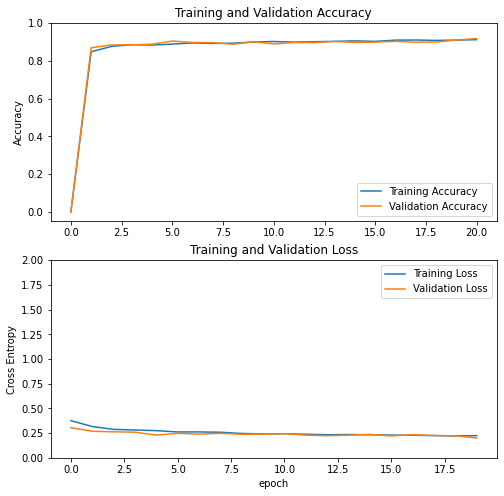

In [177]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [178]:
class_names

{'Covid': 0, 'Normal': 1}


<font color='blue'>

## 5. Confusion Matrix

In [183]:
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score

In [179]:
loss, accuracy = model.evaluate(validation_set)
print('Validation accuracy :', accuracy)

87/87 [==============================] - 14s 165ms/step - loss: 0.1999 - accuracy: 0.9175


In [180]:
# predict classes of validation dataset
val_predict = model.predict(validation_set)

In [181]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

Accuracy: 0.9174511223750905
F1 score: 0.8853190559440559
Recall: 0.86062378365985
Precision: 0.921679641799095

 clasification report:
               precision    recall  f1-score   support

       Covid       0.93      0.74      0.82       723
      Normal       0.91      0.98      0.95      2039

    accuracy                           0.92      2762
   macro avg       0.92      0.86      0.89      2762
weighted avg       0.92      0.92      0.91      2762



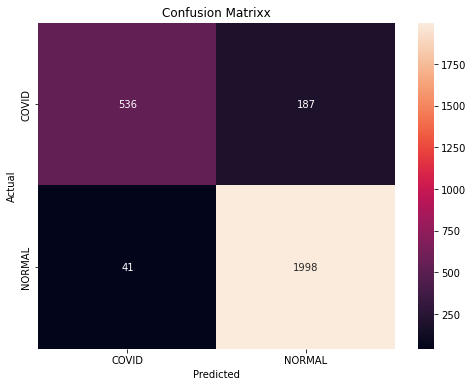

In [186]:
print ('Accuracy:', accuracy_score(validation_set.classes, predict_class))
print ('F1 score:', f1_score(validation_set.classes, predict_class, average='macro'))
print ('Recall:', recall_score(validation_set.classes, predict_class, average='macro'))
print ('Precision:', precision_score(validation_set.classes, predict_class, average='macro'))

labels = ['Covid', 'Normal',]
report = classification_report(validation_set.classes, predict_class, target_names=labels)
print('\n clasification report:\n', report)

cm = confusion_matrix(validation_set.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 5.1 AUC & ROC Curve

In [1]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(validation_set.classes, predict_class)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

NameError: name 'validation_set' is not defined

In [ ]:
import tensorflow as tf

from keras.models import load_model

model.save('MobileNetV2.h5')

The results are ok, but could be better, now let's go for fine-tuning

<font color='blue'>

## 6. Fine Tuning



We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if our accuracy improved!

### Un-freeze the top layers of the model

All we need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, we should recompile the model (necessary for these changes to take effect), and resume training.

In [188]:
# # now that the head FC layers have been trained/initialized, lets
# # unfreeze the final set of CONV layers and make them trainable
# for layer in base_model.layers[15:]:
# 	layer.trainable = True
# # loop over the layers in the model and show which ones are trainable
# # or not
# for layer in base_model.layers:
# 	print("{}: {}".format(layer, layer.trainable))

In [193]:
base_model.trainable = True

In [194]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [195]:
for layer in base_model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f7c7cd55e50>: False
<keras.layers.convolutional.Conv2D object at 0x7f7d70218050>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7d70226490>: False
<keras.layers.advanced_activations.ReLU object at 0x7f7c7d07e490>: False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f7c8cc87150>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7c7d088c10>: False
<keras.layers.advanced_activations.ReLU object at 0x7f7c7cf7a690>: False
<keras.layers.convolutional.Conv2D object at 0x7f7c7d09fe90>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7c7d0ab5d0>: False
<keras.layers.convolutional.Conv2D object at 0x7f7c7d095810>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7c7d0a9790>: False
<keras.layers.advanced_activations.ReLU object at 0x7f7c7d078e10>: False
<keras.layers.convolutional.Ze

In [196]:
base_learning_rate = 0.01

In [199]:
# Define a BinaryCrossentropy loss function. Use from_logits=True
# loss_function = tf.keras.losses.categorical_crossentropy(from_logits = True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = SGD(lr=1e-4, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

### 6.1 Compile the model

In [200]:
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=metrics)

In [202]:
# assert type(loss_function) == tf.keras.losses.categorical_crossentropy, "Not the correct layer"
# assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

All tests passed!


In [203]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [204]:
len(model.trainable_variables)

40

### 6.2 Continue Training the Model

This will improve our accuracy by a few percentage points.

In [206]:
initial_epochs = 20
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)


history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set,
                         callbacks = [early_stopper])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 20/25
346/346 [==============================] - 212s 613ms/step - loss: 0.1656 - accuracy: 0.9398 - val_loss: 4.2598 - val_accuracy: 0.4377
Epoch 21/25
346/346 [==============================] - 193s 559ms/step - loss: 0.1296 - accuracy: 0.9557 - val_loss: 1.0649 - val_accuracy: 0.7581
Epoch 22/25
346/346 [==============================] - 194s 560ms/step - loss: 0.1032 - accuracy: 0.9652 - val_loss: 0.7245 - val_accuracy: 0.7719
Epoch 23/25
346/346 [==============================] - 191s 552ms/step - loss: 0.0989 - accuracy: 0.9642 - val_loss: 2.4244 - val_accuracy: 0.7574
Epoch 24/25
346/346 [==============================] - 190s 549ms/step - loss: 0.0946 - accuracy: 0.9660 - val_loss: 3.4832 - val_accuracy: 0.7574
Epoch 25/25
346/346 [==============================] - 191s 553ms/step - loss: 0.0934 - accuracy: 0.9658 - val_loss: 0.8331 - val_accuracy: 0.8045


Learning Curve

In [207]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

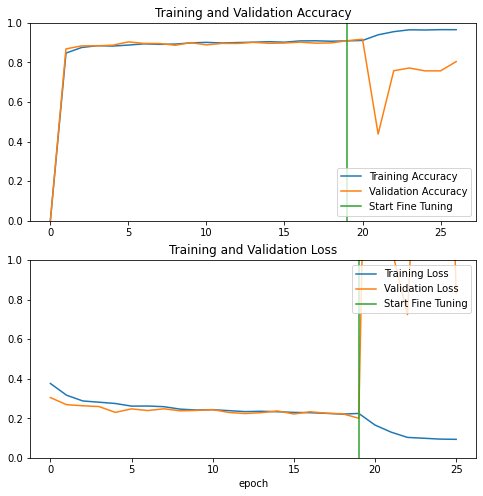

In [208]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

## 7. Evaluation and prediction

Finaly we can verify the performance of the model using Validation set.

In [209]:
loss, accuracy = model.evaluate(validation_set)
print('Validation accuracy :', accuracy)

87/87 [==============================] - 14s 165ms/step - loss: 0.8331 - accuracy: 0.8045
Test accuracy : 0.8044894933700562


### Classification Report & Confusion Matrix

In [210]:
# predict classes of validation dataset
val_predict = model.predict(validation_set)

predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

Accuracy: 0.8044895003620565
F1 score: 0.7384332088178039
Recall: 0.7310006735870442
Precision: 0.7477989988801255

 clasification report:
               precision    recall  f1-score   support

       Covid       0.64      0.58      0.61       723
      Normal       0.86      0.89      0.87      2039

    accuracy                           0.80      2762
   macro avg       0.75      0.73      0.74      2762
weighted avg       0.80      0.80      0.80      2762



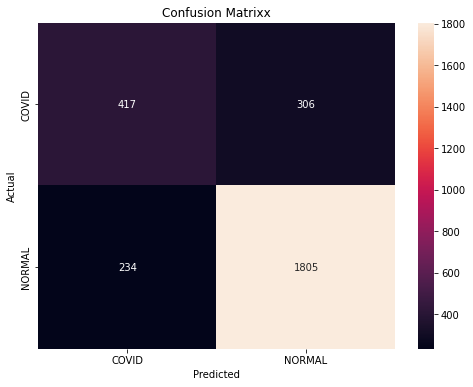

In [211]:
print ('Accuracy:', accuracy_score(validation_set.classes, predict_class))
print ('F1 score:', f1_score(validation_set.classes, predict_class, average='macro'))
print ('Recall:', recall_score(validation_set.classes, predict_class, average='macro'))
print ('Precision:', precision_score(validation_set.classes, predict_class, average='macro'))

labels = ['Covid', 'Normal',]
report = classification_report(validation_set.classes, predict_class, target_names=labels)
print('\n clasification report:\n', report)

cm = confusion_matrix(validation_set.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## More Epoch

In [213]:
initial_epochs = 25
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)


history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_set,
                         callbacks = [early_stopper])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 25/30
346/346 [==============================] - 190s 550ms/step - loss: 0.0630 - accuracy: 0.9794 - val_loss: 0.6942 - val_accuracy: 0.8588
Epoch 26/30
346/346 [==============================] - 191s 551ms/step - loss: 0.0689 - accuracy: 0.9766 - val_loss: 0.9529 - val_accuracy: 0.8052
Epoch 27/30
346/346 [==============================] - 192s 554ms/step - loss: 0.0654 - accuracy: 0.9773 - val_loss: 0.6148 - val_accuracy: 0.8472
Epoch 28/30
346/346 [==============================] - 198s 571ms/step - loss: 0.0563 - accuracy: 0.9812 - val_loss: 2.9611 - val_accuracy: 0.7944
Epoch 29/30
346/346 [==============================] - 197s 570ms/step - loss: 0.0607 - accuracy: 0.9813 - val_loss: 1.6799 - val_accuracy: 0.6970
Epoch 30/30
346/346 [==============================] - 198s 572ms/step - loss: 0.0485 - accuracy: 0.9821 - val_loss: 5.0469 - val_accuracy: 0.3537


In [ ]:
initial_epochs = 30
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)


history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_set,
                         callbacks = [early_stopper])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 30/40
346/346 [==============================] - 202s 584ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 0.5228 - val_accuracy: 0.9037
Epoch 31/40
346/346 [==============================] - 210s 606ms/step - loss: 0.0626 - accuracy: 0.9794 - val_loss: 0.9036 - val_accuracy: 0.8563
Epoch 32/40
346/346 [==============================] - 197s 569ms/step - loss: 0.0446 - accuracy: 0.9842 - val_loss: 7.8568 - val_accuracy: 0.3059
Epoch 33/40
346/346 [==============================] - 197s 568ms/step - loss: 0.0503 - accuracy: 0.9831 - val_loss: 11.5121 - val_accuracy: 0.5098
Epoch 34/40
 50/346 [===>..........................] - ETA: 2:35 - loss: 0.0410 - accuracy: 0.9856

In [ ]:
import tensorflow as tf

from keras.models import load_model

model.save('COVID19_MobileNetV2_Epoch-40.h5')

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_set)
print('Validation accuracy :', accuracy)

In [ ]:
# predict classes of validation dataset
val_predict = model.predict(validation_set)

predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [ ]:
print ('Accuracy:', accuracy_score(validation_set.classes, predict_class))
print ('F1 score:', f1_score(validation_set.classes, predict_class, average='macro'))
print ('Recall:', recall_score(validation_set.classes, predict_class, average='macro'))
print ('Precision:', precision_score(validation_set.classes, predict_class, average='macro'))

labels = ['Covid', 'Normal',]
report = classification_report(validation_set.classes, predict_class, target_names=labels)
print('\n clasification report:\n', report)

cm = confusion_matrix(validation_set.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Extra 

In [145]:
# model.evaluate(train_set)

In [2]:
# model.evaluate(validation_set)

## Done! 

<font color='DarkViolet'>

**Important Points**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 